The code in this notebook is based on:

- [Huggingface notebook: Text Classification on GLUE](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [Answer.AI notebook: Finetune ModernBERT on GLUE](https://colab.research.google.com/github/AnswerDotAI/ModernBERT/blob/main/examples/finetune_modernbert_on_glue.ipynb)
- [Huggingface `transformers`: `run_glue.py` script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py)
- [BERT Fine-Tuning Tutorial with PyTorch by Chris McCormick](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

# Fine-Tuning BERT on GLUE - MNLI

From [GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding - Wang et al.](https://arxiv.org/pdf/1804.07461):

The Multi-Genre Natural Language Inference Corpus (Williams et al., 2018) is a crowdsourced collection of sentence pairs with textual entailment annotations. Given a premise sentence
and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are
gathered from ten different sources, including transcribed speech, fiction, and government reports.
We use the standard test set, for which we obtained private labels from the authors, and evaluate
on both the matched (in-domain) and mismatched (cross-domain) sections. We also use and recommend the SNLI corpus (Bowman et al., 2015) as 550k examples of auxiliary training data.

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
from pathlib import Path

import numpy as np
from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)
np.random.seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "mnli"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA A40

==============NVSMI LOG==============

Timestamp                                 : Mon Jan 20 07:41:58 2025
Driver Version                            : 550.90.07
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:05:00.0
    FB Memory Usage
        Total                             : 46068 MiB
        Reserved                          : 665 MiB
        Used                              : 4 MiB
        Free                              : 45401 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 2 MiB
        Free                              : 65534 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [5]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [6]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

The MNLI dataset is special, as it provides two validation and two test datasets. One matched (in-domain) and one mismatched (cross-domain).

In [7]:
pd.DataFrame(dataset["train"]).sample(10)

,premise,hypothesis,label,idx
155219,That's all right.,That's fine.,0,155219
327538,Televisions are expensive these days.,Televisions cost $200 when you purchase them f...,1,327538
325456,The colonial porte cochre sets the tone for Wa...,The colonial porte coche on the front of the p...,1,325456
341461,and you just sift,"Don't sift, ever.",2,341461
54698,You think there's somethin' in all that talk T...,Topham had supported the talk due to his own d...,1,54698
38374,are the uh Oldsmobiles that you're looking at ...,Are the cars you're looking at for scrap only?,2,38374
284865,and she's doing it i mean it's not like it's like,She is doing something,0,284865
333146,"Ancient and ill-maintained, it starts off shin...",The line gets in worse condition as it gets cl...,0,333146
216074,One of the first impressions you'll get at the...,Dehli is not considered a very diverse place.,2,216074
125620,what about people from uh Pennsylvania what do...,do people in Pennsylvania think people in Texa...,1,125620


In [8]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0, 2])
num_labels=3


The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [9]:
pd.DataFrame(dataset["test_matched"]).sample(10)

,premise,hypothesis,label,idx
1962,"This is still a beta, meaning that we're still...",The product is now out of beta.,-1,1962
8956,There are several reasons for this large diffe...,There are many reasons that explain the differ...,-1,8956
7144,"As you're bent on it, I'd go right ahead with ...",The quiet American stayed silent the whole tim...,-1,7144
5446,(Deputy Treasury Secretary Lawrence Summers on...,Treasurer Secretary Lawrence Summers endorsed ...,-1,5446
8489,"As discussed above, significant variability ex...",The results of mortality studies are accurate.,-1,8489
1031,His tunic was tied with a line of rope but a p...,He was standing naked in the crowd.,-1,1031
2821,yeah well they're working on diapers which w...,I've read that originally they thought the dis...,-1,2821
4797,"From two cities, two frogs ...",Two frogs from different places,-1,4797
2205,"From a macroeconomic perspective, increasing t...","According to macroeconomics, merely increasing...",-1,2205
7646,"It took the sculptors Jean de Marville, Claus ...",The sculptures for the mausoleum of Philippe l...,-1,7646


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the validation datasets to create two custom test datasets for our experiment. We will keep the train split as it is.

We will use the first split (80%) as new matched validation dataset and use the second split as new matched test dataset:

In [10]:
new_matched_validation_test_split = dataset["validation_matched"].train_test_split(test_size=0.2)
new_matched_validation_test_split["validation_matched"] = new_matched_validation_test_split.pop("train")
new_matched_validation_test_split["test_matched"] = new_matched_validation_test_split.pop("test")
new_matched_validation_test_split

DatasetDict({
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 7852
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1963
    })
})

And we do the same for the mismatched case:

In [11]:
new_mismatched_validation_test_split = dataset["validation_mismatched"].train_test_split(test_size=0.2)
new_mismatched_validation_test_split["validation_mismatched"] = new_mismatched_validation_test_split.pop("train")
new_mismatched_validation_test_split["test_mismatched"] = new_mismatched_validation_test_split.pop("test")
new_mismatched_validation_test_split

DatasetDict({
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 7865
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1967
    })
})

In [12]:
dataset["validation_matched"] = new_matched_validation_test_split["validation_matched"]
dataset["test_matched"] = new_matched_validation_test_split["test_matched"]
dataset["validation_mismatched"] = new_mismatched_validation_test_split["validation_mismatched"]
dataset["test_mismatched"] = new_mismatched_validation_test_split["test_mismatched"]
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 7852
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 7865
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1963
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1967
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [13]:
pd.DataFrame(dataset["test_matched"]).sample(10)

,premise,hypothesis,label,idx
885,"If you still want to join, it might be worked.",It's too late to try anything now because you ...,2,1967
1042,"The unintended side effect is radical, direct ...",There is a radical side effect that was not in...,1,6192
182,"It has a full program of events, including lec...","There are a full slate of events, including se...",0,6694
1640,that's hilarious to to get that jack off that'...,It's a hilarious story.,0,706
747,"EPA estimates that 5.6 million acres of lakes,...",The release of mercury has an impact on rivers...,0,4419
1897,"(The Ramseys buried their daughter in Atlanta,...",The Ramseys went on vacation to relieve themse...,1,2935
344,Visit at sundown or out of season to get the f...,The setting is better to visit at sundown or d...,0,94
230,Postal Service could increase those same rates...,The Postal Service would like to see the rates...,1,4247
907,Critics praise Goodman's finely honed descript...,Critics believe Goodman played a great father ...,1,9250
1506,We also have found that leading organizations ...,Leading organizations want to be sure their pr...,1,637


In [14]:
pd.DataFrame(dataset["test_mismatched"]).sample(10)

,premise,hypothesis,label,idx
153,"For example, students are provided both tradit...",Students are given a thorough and cultured edu...,1,1378
1092,I just loved Cinderella . I also saw my sister...,My sisters were very similar in temperament to...,0,2872
930,Your contribution is more than a simple tax-de...,Your contribution and a simple donation aren't...,0,6491
1912,"Paula Van Gelder's Poetic Licenses [XIV, 4] ...",Paula Van Gelder's personal portraits reminded...,2,6013
1546,What has your support of our campers meant to ...,You need to tell me of your experience with th...,0,5441
1628,Your support for our work would be greatly app...,Our preferred form of support is financial con...,1,1105
1451,"During my time in senior high, and, after that...",I was worried about a lot of things back then.,0,8006
1294,Please renew your commitment today.,A renewal of commitment is required today,0,67
43,She did not display signs of panic and did not...,She didn't show that she was upset or that she...,1,594
113,Perhaps one day we shall find an Etruscan libr...,"We have to make do with what he have for now, ...",0,5260


## 2. BERT-base

In [15]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [17]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 444
Max length in split='validation_matched': 233
Max length in split='validation_mismatched': 211
Max length in split='test_matched': 237
Max length in split='test_mismatched': 206


In [18]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/7865 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [19]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
premise,Conceptually cream skimming has two basic dimensions - product and geography.
hypothesis,Product and geography are what make cream skimming work.
label,1
idx,0
input_ids,"[101, 17158, 2135, 6949, 8301, 25057, 2038, 2048, 3937, 9646, 1011, 4031, 1998, 10505, 1012, 102, 4031, 1998, 10505, 2024, 2054, 2191, 6949, 8301, 25057, 2147, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,101,17158,2135,6949,8301,25057,2038,2048,3937,9646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,2017,2113,2076,1996,2161,1998,1045,3984,2012,...,2000.0,1996.0,2206.0,2504.0,2065.0,1996.0,2111.0,9131.0,1012.0,102.0
2,101,2028,1997,2256,2193,2097,4287,2041,2115,8128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,101,17158,2135,6949,8301,25057,2038,2048,3937,9646,...,0,0,0,0,0,0,0,0,0,0
1,101,2017,2113,2076,1996,2161,1998,1045,3984,2012,...,2000,1996,2206,2504,2065,1996,2111,9131,1012,102
2,101,2028,1997,2256,2193,2097,4287,2041,2115,8128,...,0,0,0,0,0,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [22]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [23]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [24]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task mnli


In [25]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [26]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy_avg",  # `eval_accuracy_avg` will be computed via a custom callback to be the avg of the accuracy for both validation datasets (matched and mismatched)
)

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

As this dataset provides two different evaluation datasets (matched and mismatched) we will perform two evaluations on each `eval_step`. We will then compute an average of both evaluation results and store the average within `transformer`s `metrics` dictionary as `eval_accuracy_avg`. We will also use this computed average as `metric_for_best_model`.

In [29]:
from transformers import TrainerCallback, TrainerState, TrainerControl


class AverageMatchedAndMismatchedAccuracies(TrainerCallback):
    """Callback to save the `eval_mnli_matched_accuracy` after the first evaluation step (MLNI matched)
    and then compute the average of (MLNI matched acc. and mismatched acc.) on the second evaluation step
    """

    matched_acc = None

    def on_evaluate(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        metrics: dict[str, float],
        **kwargs
    ):
        """Event called after an evaluation phase."""
        if self.matched_acc is None:
            # We are in the first evaluation step (matched) - save result metric for later use
            self.matched_acc = metrics["eval_mnli_matched_accuracy"]
            return

        # We are in the second evaluation step (mismatched)
        # Use the `matched_acc` saved before and the `mismatched_acc` to compute average:
        mismatched_acc = metrics["eval_mnli_mismatched_accuracy"]
        metrics["eval_accuracy_avg"] = (self.matched_acc + mismatched_acc) / 2

        self.matched_acc = None
        return

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset={
        "mnli_matched": tokenized_dataset["validation_matched"],
        "mnli_mismatched": tokenized_dataset["validation_mismatched"],
    },
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[AverageMatchedAndMismatchedAccuracies]
)

In [31]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-mnli/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='eval_accuracy_avg'


Epoch,Training Loss,Validation Loss,Mnli Matched Loss,Mnli Matched Accuracy,Mnli Mismatched Loss,Mnli Mismatched Accuracy,Accuracy Avg
1,0.521100,No log,0.440432,0.828833,0.410879,0.842339,0.835586
2,0.343900,No log,0.449641,0.837876,0.418943,0.846917,0.842396
3,0.231900,No log,0.516333,0.832017,0.466534,0.844882,0.838450
4,0.156400,No log,0.629729,0.838512,0.574196,0.848442,0.843477
5,0.112400,No log,0.742766,0.838130,0.685541,0.845264,0.841697


In [32]:
training_summary_bert_base

TrainOutput(global_step=61360, training_loss=0.27313888728851754, metrics={'train_runtime': 8199.3802, 'train_samples_per_second': 239.471, 'train_steps_per_second': 7.483, 'total_flos': 9.422162303349373e+16, 'train_loss': 0.27313888728851754, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [33]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_mnli_matched_loss': 0.6297287344932556,
 'eval_mnli_matched_accuracy': 0.8385124808965868,
 'eval_mnli_matched_runtime': 9.7758,
 'eval_mnli_matched_samples_per_second': 803.206,
 'eval_mnli_matched_steps_per_second': 25.164,
 'epoch': 5.0,
 'eval_mnli_mismatched_loss': 0.5741962790489197,
 'eval_mnli_mismatched_accuracy': 0.8484424666242848,
 'eval_mnli_mismatched_runtime': 10.6677,
 'eval_mnli_mismatched_samples_per_second': 737.274,
 'eval_mnli_mismatched_steps_per_second': 23.06,
 'eval_accuracy_avg': 0.8434774737604358}

In [34]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_mnli_matched_loss,eval_mnli_matched_accuracy,eval_mnli_matched_runtime,eval_mnli_matched_samples_per_second,eval_mnli_matched_steps_per_second,eval_mnli_mismatched_loss,eval_mnli_mismatched_accuracy,eval_mnli_mismatched_runtime,eval_mnli_mismatched_samples_per_second,eval_mnli_mismatched_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,,,,
1,0.5211,6.613205,0.000016,12272,0.440432,0.828833,9.7974,801.434,25.109,0.410879,0.842339,10.2059,770.632,24.104,NaN,NaN,NaN,NaN,NaN
2,0.3439,5.330618,0.000012,24544,0.449641,0.837876,9.8078,800.590,25.082,0.418943,0.846917,10.2093,770.376,24.096,NaN,NaN,NaN,NaN,NaN
3,0.2319,8.503725,0.000008,36816,0.516333,0.832017,9.7968,801.489,25.110,0.466534,0.844882,10.2080,770.474,24.099,NaN,NaN,NaN,NaN,NaN
4,0.1564,1.596755,0.000004,49088,0.629729,0.838512,9.7853,802.431,25.140,0.574196,0.848442,10.1927,771.628,24.135,NaN,NaN,NaN,NaN,NaN
5,0.1124,18.429760,0.000000,61360,0.742766,0.838130,9.8072,800.638,25.084,0.685541,0.845264,10.2003,771.059,24.117,8199.3802,239.471,7.483,9.422162e+16,0.273139


### Loss and Evaluation Metrics over Training  Epochs (matched google-bert/bert-base-uncased)

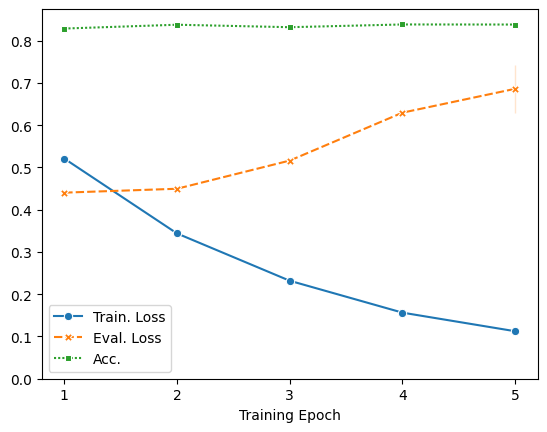

In [35]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_mnli_matched_loss", "epoch", "eval_mnli_matched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training  Epochs (matched {PRE_TRAINED_CHECKPOINT})"))

### Loss and Evaluation Metrics over Training Steps (mismatched google-bert/bert-base-uncased)

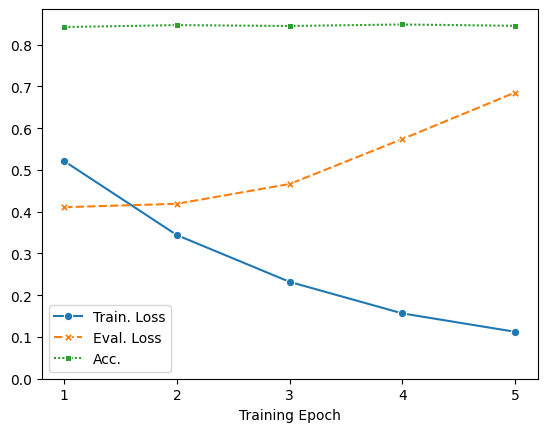

In [36]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_mnli_mismatched_loss", "epoch", "eval_mnli_mismatched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Steps (mismatched {PRE_TRAINED_CHECKPOINT})"))

### 2.4 Evaluation

### Label frequency in matched test dataset

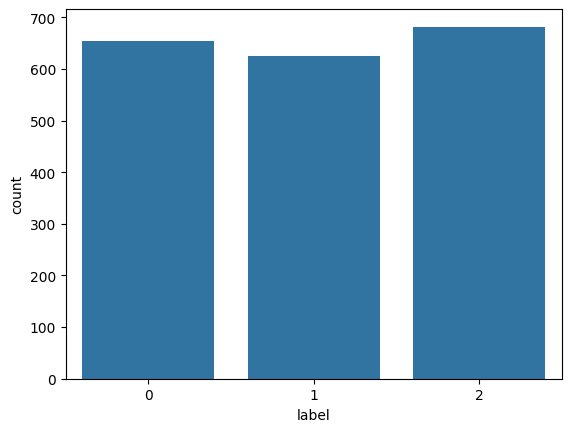

In [37]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test_matched"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in matched test dataset"))

### Label frequency in mismatched test dataset

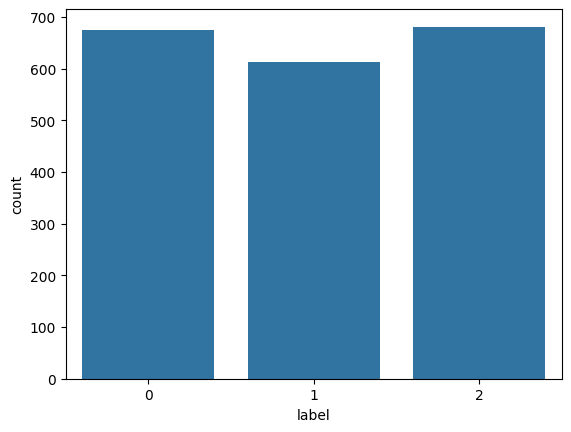

In [38]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test_mismatched"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in mismatched test dataset"))

The dataset classes seem to be somewhat balanced.

In [39]:
predictions_matched = trainer.predict(tokenized_dataset["test_matched"])
predictions_mismatched = trainer.predict(tokenized_dataset["test_mismatched"])

### Prediction Confusion Matrix (matchded - google-bert/bert-base-uncased)

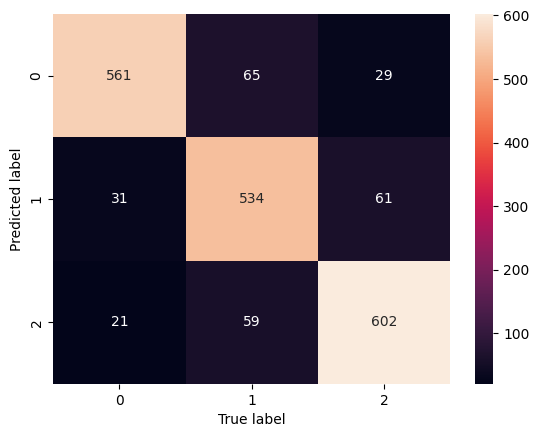

In [40]:
import sklearn.metrics

bert_base_matched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_matched"]["label"],
    predictions_matched.predictions.argmax(-1),
)
plot = sns.heatmap(bert_base_matched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(f"### Prediction Confusion Matrix (matchded - {PRE_TRAINED_CHECKPOINT})")
)

### Prediction Confusion Matrix (mismatchded - google-bert/bert-base-uncased)

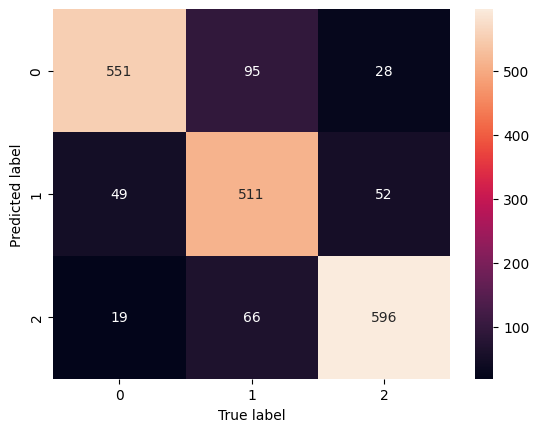

In [41]:
import sklearn.metrics

bert_base_mismatched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_mismatched"]["label"],
    predictions_mismatched.predictions.argmax(-1),
)
plot = sns.heatmap(bert_base_mismatched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(
        f"### Prediction Confusion Matrix (mismatchded - {PRE_TRAINED_CHECKPOINT})"
    )
)

In [42]:
predictions_matched.metrics

{'test_loss': 0.5101571083068848,
 'test_accuracy': 0.8644931227712684,
 'test_runtime': 2.5723,
 'test_samples_per_second': 763.12,
 'test_steps_per_second': 24.103}

In [43]:
predictions_mismatched.metrics

{'test_loss': 0.6029943227767944,
 'test_accuracy': 0.8429079816980173,
 'test_runtime': 2.4968,
 'test_samples_per_second': 787.815,
 'test_steps_per_second': 24.832}

In [44]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    data=[training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [
        predictions_matched.metrics["test_accuracy"],
        predictions_mismatched.metrics["test_accuracy"],
    ],
    index=["train_runtime_s"]
    + list(best_model_evaluation.keys())
    + [
        "matched_test_accuracy",
        "mismatched_test_accuracy",
    ],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=[
        "eval_mnli_matched_runtime",
        "eval_mnli_mismatched_runtime",
        "eval_mnli_matched_samples_per_second",
        "eval_mnli_mismatched_samples_per_second",
        "eval_mnli_matched_steps_per_second",
        "eval_mnli_mismatched_steps_per_second",
        "epoch",
    ]
)
# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-", "-", "-", "-", 0.846, 0.834]
results["original BERT_LARGE"] = ["-", "-", "-", "-", "-", "-", 0.867, 0.859]
print(
    f'"Our Model" based on {PRE_TRAINED_CHECKPOINT}, best performance on validation data.'
)
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"Our Model" based on google-bert/bert-base-uncased, best performance on validation data.
"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,8199.380200,-,-
eval_mnli_matched_loss,0.629729,-,-
eval_mnli_matched_accuracy,0.838512,-,-
eval_mnli_mismatched_loss,0.574196,-,-
eval_mnli_mismatched_accuracy,0.848442,-,-
eval_accuracy_avg,0.843477,-,-
matched_test_accuracy,0.864493,0.846,0.867
mismatched_test_accuracy,0.842908,0.834,0.859


## 3. BERT-Large

In [45]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/7852 [00:00<?, ? examples/s]

In [47]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [48]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task mnli


In [49]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [50]:
BATCH_SIZE = 32  # BERT-large might need a smaller batch size

In [51]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

12509

In [52]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy_avg",  # `eval_accuracy_avg` will be computed via a custom callback to be the avg of the accuracy for both validation datasets (matched and mismatched)
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset={
        "mnli_matched": tokenized_dataset["validation_matched"],
        "mnli_mismatched": tokenized_dataset["validation_mismatched"],
    },
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[AverageMatchedAndMismatchedAccuracies]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-mnli/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='eval_accuracy_avg'


Epoch,Training Loss,Validation Loss,Mnli Matched Loss,Mnli Matched Accuracy,Mnli Mismatched Loss,Mnli Mismatched Accuracy,Accuracy Avg
1,0.463900,No log,0.381661,0.854559,0.364187,0.858741,0.856650
2,0.272400,No log,0.408552,0.855833,0.397775,0.858996,0.857414
3,0.155700,No log,0.518314,0.856342,0.512647,0.856071,0.856207
4,0.094700,No log,0.680571,0.862837,0.677831,0.859758,0.861298
5,0.058800,No log,0.851048,0.859526,0.848067,0.859631,0.859579


In [54]:
training_summary_bert_large

TrainOutput(global_step=61360, training_loss=0.20909234734526513, metrics={'train_runtime': 25481.0523, 'train_samples_per_second': 77.058, 'train_steps_per_second': 2.408, 'total_flos': 3.3372825700740736e+17, 'train_loss': 0.20909234734526513, 'epoch': 5.0})

In [55]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_mnli_matched_loss': 0.6805709600448608,
 'eval_mnli_matched_accuracy': 0.8628374936321956,
 'eval_mnli_matched_runtime': 31.0151,
 'eval_mnli_matched_samples_per_second': 253.167,
 'eval_mnli_matched_steps_per_second': 7.932,
 'epoch': 5.0,
 'eval_mnli_mismatched_loss': 0.67783123254776,
 'eval_mnli_mismatched_accuracy': 0.859758423394787,
 'eval_mnli_mismatched_runtime': 32.3985,
 'eval_mnli_mismatched_samples_per_second': 242.758,
 'eval_mnli_mismatched_steps_per_second': 7.593,
 'eval_accuracy_avg': 0.8612979585134913}

In [56]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_mnli_matched_loss,eval_mnli_matched_accuracy,eval_mnli_matched_runtime,eval_mnli_matched_samples_per_second,eval_mnli_matched_steps_per_second,eval_mnli_mismatched_loss,eval_mnli_mismatched_accuracy,eval_mnli_mismatched_runtime,eval_mnli_mismatched_samples_per_second,eval_mnli_mismatched_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,,,,
1,0.4639,7.437689,0.000016,12272,0.381661,0.854559,31.1664,251.938,7.893,0.364187,0.858741,32.4431,242.425,7.583,NaN,NaN,NaN,NaN,NaN
2,0.2724,2.881418,0.000012,24544,0.408552,0.855833,31.1541,252.037,7.896,0.397775,0.858996,32.4780,242.164,7.574,NaN,NaN,NaN,NaN,NaN
3,0.1557,12.263826,0.000008,36816,0.518314,0.856342,31.1461,252.102,7.898,0.512647,0.856071,32.4539,242.344,7.580,NaN,NaN,NaN,NaN,NaN
4,0.0947,8.062838,0.000004,49088,0.680571,0.862837,31.9107,246.062,7.709,0.677831,0.859758,32.9574,238.641,7.464,NaN,NaN,NaN,NaN,NaN
5,0.0588,19.500519,0.000000,61360,0.851048,0.859526,31.0866,252.585,7.913,0.848067,0.859631,32.4297,242.524,7.586,25481.0523,77.058,2.408,3.337283e+17,0.209092


### Loss and Evaluation Metrics over Training  Epochs (matched google-bert/bert-large-uncased)

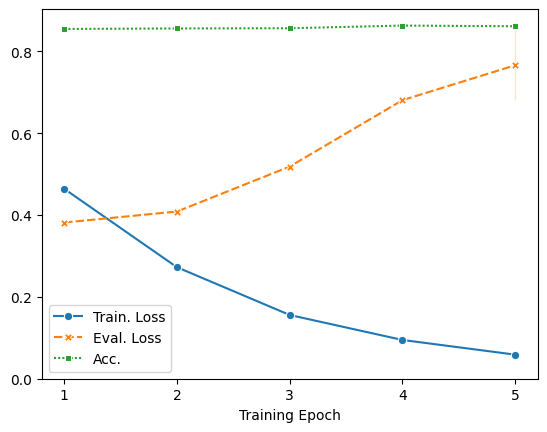

In [57]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_mnli_matched_loss", "epoch", "eval_mnli_matched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training  Epochs (matched {PRE_TRAINED_CHECKPOINT})"))

### Loss and Evaluation Metrics over Training Steps (mismatched google-bert/bert-large-uncased)

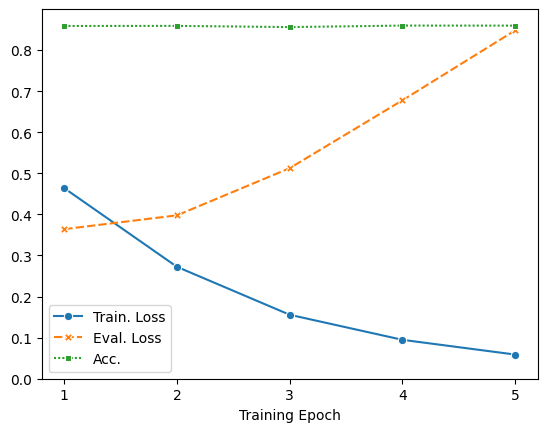

In [58]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_mnli_mismatched_loss", "epoch", "eval_mnli_mismatched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Steps (mismatched {PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [59]:
predictions_matched = trainer.predict(tokenized_dataset["test_matched"])
predictions_mismatched = trainer.predict(tokenized_dataset["test_mismatched"])

### Prediction Confusion Matrix (matchded - google-bert/bert-large-uncased)

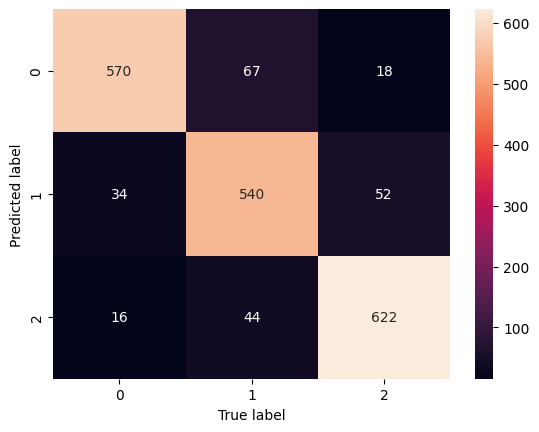

In [60]:
import sklearn.metrics

bert_large_matched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_matched"]["label"],
    predictions_matched.predictions.argmax(-1),
)
plot = sns.heatmap(bert_large_matched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(f"### Prediction Confusion Matrix (matchded - {PRE_TRAINED_CHECKPOINT})")
)

### Prediction Confusion Matrix (mismatchded - google-bert/bert-large-uncased)

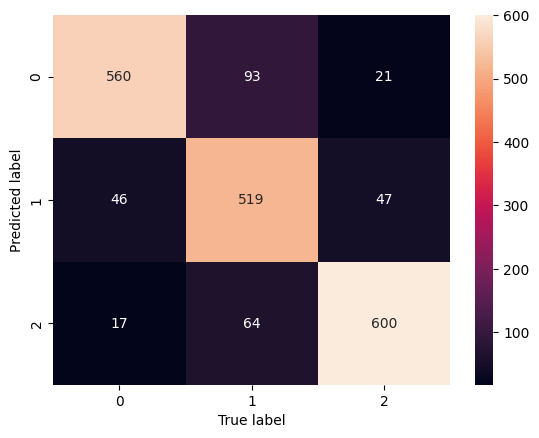

In [61]:
import sklearn.metrics

bert_large_mismatched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_mismatched"]["label"],
    predictions_mismatched.predictions.argmax(-1),
)
plot = sns.heatmap(bert_large_mismatched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(
        f"### Prediction Confusion Matrix (mismatchded - {PRE_TRAINED_CHECKPOINT})"
    )
)

In [62]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_mnli_matched_loss"],
    best_model_evaluation["eval_mnli_matched_accuracy"],
    best_model_evaluation["eval_mnli_mismatched_loss"],
    best_model_evaluation["eval_mnli_mismatched_accuracy"],
    best_model_evaluation["eval_accuracy_avg"],
    predictions_matched.metrics["test_accuracy"],
    predictions_mismatched.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,8199.380200,-,25481.052300,-
eval_mnli_matched_loss,0.629729,-,0.680571,-
eval_mnli_matched_accuracy,0.838512,-,0.862837,-
eval_mnli_mismatched_loss,0.574196,-,0.677831,-
eval_mnli_mismatched_accuracy,0.848442,-,0.859758,-
eval_accuracy_avg,0.843477,-,0.861298,-
matched_test_accuracy,0.864493,0.846,0.882323,0.867
mismatched_test_accuracy,0.842908,0.834,0.853584,0.859


## 4. ModernBERT-base

In [63]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [64]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/7852 [00:00<?, ? examples/s]

In [65]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [66]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task mnli


In [67]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [68]:
BATCH_SIZE = 32

In [69]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

10621

In [70]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy_avg",  # `eval_accuracy_avg` will be computed via a custom callback to be the avg of the accuracy for both validation datasets (matched and mismatched)
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset={
        "mnli_matched": tokenized_dataset["validation_matched"],
        "mnli_mismatched": tokenized_dataset["validation_mismatched"],
    },
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[AverageMatchedAndMismatchedAccuracies]
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-mnli/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='eval_accuracy_avg'


Epoch,Training Loss,Validation Loss,Mnli Matched Loss,Mnli Matched Accuracy,Mnli Mismatched Loss,Mnli Mismatched Accuracy,Accuracy Avg
1,0.406300,No log,0.365225,0.858635,0.351351,0.866370,0.862502
2,0.223900,No log,0.370408,0.866786,0.354580,0.875143,0.870964
3,0.104000,No log,0.475809,0.864748,0.452129,0.871202,0.867975
4,0.044900,No log,0.654269,0.869969,0.636583,0.875270,0.872620
5,0.013300,No log,0.915782,0.870352,0.894852,0.872219,0.871285


In [72]:
training_summary_modernbert_base

TrainOutput(global_step=61360, training_loss=0.15847357559701455, metrics={'train_runtime': 5936.7764, 'train_samples_per_second': 330.737, 'train_steps_per_second': 10.336, 'total_flos': 1.209731724286496e+17, 'train_loss': 0.15847357559701455, 'epoch': 5.0})

In [73]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_mnli_matched_loss': 0.6542551517486572,
 'eval_mnli_matched_accuracy': 0.8697147223637289,
 'eval_mnli_matched_runtime': 6.0622,
 'eval_mnli_matched_samples_per_second': 1295.245,
 'eval_mnli_matched_steps_per_second': 40.58,
 'epoch': 5.0,
 'eval_mnli_mismatched_loss': 0.6368789672851562,
 'eval_mnli_mismatched_accuracy': 0.8748887476160203,
 'eval_mnli_mismatched_runtime': 6.5124,
 'eval_mnli_mismatched_samples_per_second': 1207.689,
 'eval_mnli_mismatched_steps_per_second': 37.774,
 'eval_accuracy_avg': 0.8723017349898746}

In [74]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_mnli_matched_loss,eval_mnli_matched_accuracy,eval_mnli_matched_runtime,eval_mnli_matched_samples_per_second,eval_mnli_matched_steps_per_second,eval_mnli_mismatched_loss,eval_mnli_mismatched_accuracy,eval_mnli_mismatched_runtime,eval_mnli_mismatched_samples_per_second,eval_mnli_mismatched_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,,,,
1,0.4063,3.258084,0.000064,12272,0.365225,0.858635,6.1968,1267.113,39.698,0.351351,0.866370,6.4714,1215.343,38.013,NaN,NaN,NaN,NaN,NaN
2,0.2239,1.941916,0.000048,24544,0.370408,0.866786,6.1402,1278.788,40.064,0.354580,0.875143,6.4284,1223.472,38.268,NaN,NaN,NaN,NaN,NaN
3,0.1040,2.066180,0.000032,36816,0.475809,0.864748,6.1577,1275.142,39.950,0.452129,0.871202,6.4666,1216.255,38.042,NaN,NaN,NaN,NaN,NaN
4,0.0449,0.058064,0.000016,49088,0.654269,0.869969,6.3393,1238.617,38.805,0.636583,0.875270,6.5684,1197.395,37.452,NaN,NaN,NaN,NaN,NaN
5,0.0133,0.016659,0.000000,61360,0.915782,0.870352,6.3099,1244.400,38.987,0.894852,0.872219,6.6948,1174.794,36.745,5936.7764,330.737,10.336,1.209732e+17,0.158474


### Loss and Evaluation Metrics over Training  Epochs (matched answerdotai/ModernBERT-base)

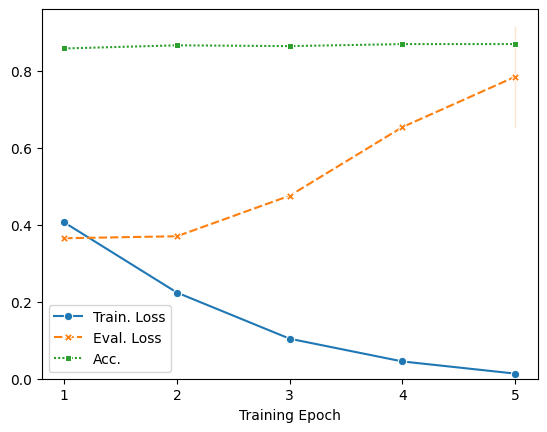

In [75]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_mnli_matched_loss", "epoch", "eval_mnli_matched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training  Epochs (matched {PRE_TRAINED_CHECKPOINT})"))

### Loss and Evaluation Metrics over Training Steps (mismatched answerdotai/ModernBERT-base)

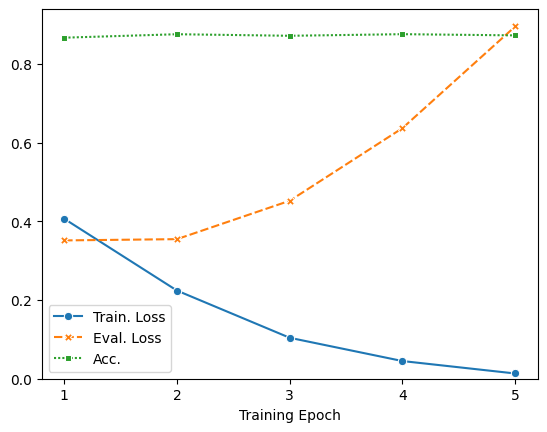

In [76]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_mnli_mismatched_loss", "epoch", "eval_mnli_mismatched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Steps (mismatched {PRE_TRAINED_CHECKPOINT})"))

### 4.4 Evaluation

In [77]:
predictions_matched = trainer.predict(tokenized_dataset["test_matched"])
predictions_mismatched = trainer.predict(tokenized_dataset["test_mismatched"])

### Prediction Confusion Matrix (matchded - answerdotai/ModernBERT-base)

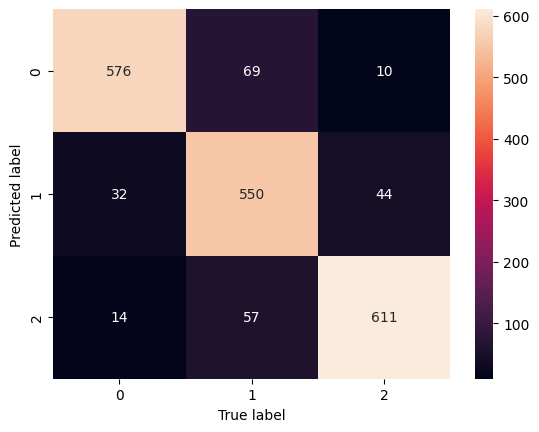

In [78]:
import sklearn.metrics

modernbert_base_matched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_matched"]["label"],
    predictions_matched.predictions.argmax(-1),
)
plot = sns.heatmap(modernbert_base_matched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(f"### Prediction Confusion Matrix (matchded - {PRE_TRAINED_CHECKPOINT})")
)

### Prediction Confusion Matrix (mismatchded - answerdotai/ModernBERT-base)

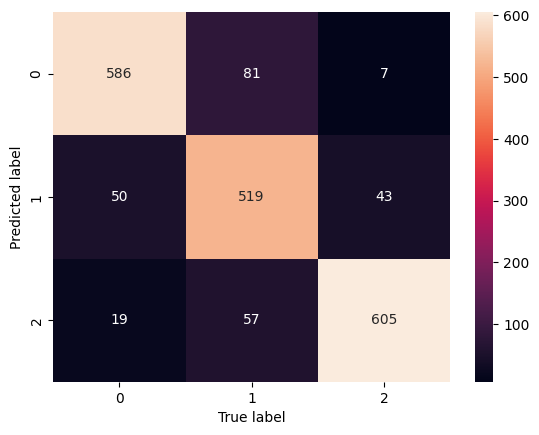

In [79]:
import sklearn.metrics

modernbert_base_mismatched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_mismatched"]["label"],
    predictions_mismatched.predictions.argmax(-1),
)
plot = sns.heatmap(modernbert_base_mismatched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(
        f"### Prediction Confusion Matrix (mismatchded - {PRE_TRAINED_CHECKPOINT})"
    )
)

In [80]:
predictions_matched.metrics

{'test_loss': 0.5879417061805725,
 'test_accuracy': 0.8848700967906266,
 'test_runtime': 1.6497,
 'test_samples_per_second': 1189.929,
 'test_steps_per_second': 37.583}

In [81]:
predictions_mismatched.metrics

{'test_loss': 0.7040250301361084,
 'test_accuracy': 0.8693441789527199,
 'test_runtime': 1.5684,
 'test_samples_per_second': 1254.124,
 'test_steps_per_second': 39.53}

In [82]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_mnli_matched_loss"],
    best_model_evaluation["eval_mnli_matched_accuracy"],
    best_model_evaluation["eval_mnli_mismatched_loss"],
    best_model_evaluation["eval_mnli_mismatched_accuracy"],
    best_model_evaluation["eval_accuracy_avg"],
    predictions_matched.metrics["test_accuracy"],
    predictions_mismatched.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,8199.380200,-,5936.776400,25481.052300,-
eval_mnli_matched_loss,0.629729,-,0.654255,0.680571,-
eval_mnli_matched_accuracy,0.838512,-,0.869715,0.862837,-
eval_mnli_mismatched_loss,0.574196,-,0.636879,0.677831,-
eval_mnli_mismatched_accuracy,0.848442,-,0.874889,0.859758,-
eval_accuracy_avg,0.843477,-,0.872302,0.861298,-
matched_test_accuracy,0.864493,0.846,0.884870,0.882323,0.867
mismatched_test_accuracy,0.842908,0.834,0.869344,0.853584,0.859


## 5. ModernBERT-Large

In [83]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [84]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/7852 [00:00<?, ? examples/s]

In [85]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [86]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task mnli


In [87]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [88]:
BATCH_SIZE = 32

In [89]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [90]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy_avg",  # `eval_accuracy_avg` will be computed via a custom callback to be the avg of the accuracy for both validation datasets (matched and mismatched)
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset={
        "mnli_matched": tokenized_dataset["validation_matched"],
        "mnli_mismatched": tokenized_dataset["validation_mismatched"],
    },
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[AverageMatchedAndMismatchedAccuracies]
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-mnli/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='eval_accuracy_avg'


Epoch,Training Loss,Validation Loss,Mnli Matched Loss,Mnli Matched Accuracy,Mnli Mismatched Loss,Mnli Mismatched Accuracy,Accuracy Avg
1,0.385100,No log,0.358660,0.864620,0.326585,0.873999,0.869310
2,0.214200,No log,0.355632,0.875064,0.337113,0.880356,0.877710
3,0.097100,No log,0.450080,0.879139,0.442857,0.878322,0.878730
4,0.040200,No log,0.655105,0.877229,0.634476,0.882136,0.879682
5,0.011700,No log,0.882326,0.874682,0.839793,0.882899,0.878790


In [92]:
training_summary_modernbert_large

TrainOutput(global_step=61360, training_loss=0.1496675772337435, metrics={'train_runtime': 13041.2774, 'train_samples_per_second': 150.561, 'train_steps_per_second': 4.705, 'total_flos': 3.754437385740197e+17, 'train_loss': 0.1496675772337435, 'epoch': 5.0})

In [93]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_mnli_matched_loss': 0.6552894711494446,
 'eval_mnli_matched_accuracy': 0.8773560876209883,
 'eval_mnli_matched_runtime': 12.1112,
 'eval_mnli_matched_samples_per_second': 648.327,
 'eval_mnli_matched_steps_per_second': 20.312,
 'epoch': 5.0,
 'eval_mnli_mismatched_loss': 0.6345316767692566,
 'eval_mnli_mismatched_accuracy': 0.8822631913541005,
 'eval_mnli_mismatched_runtime': 13.1074,
 'eval_mnli_mismatched_samples_per_second': 600.045,
 'eval_mnli_mismatched_steps_per_second': 18.768,
 'eval_accuracy_avg': 0.8798096394875443}

In [94]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_mnli_matched_loss,eval_mnli_matched_accuracy,eval_mnli_matched_runtime,eval_mnli_matched_samples_per_second,eval_mnli_matched_steps_per_second,eval_mnli_mismatched_loss,eval_mnli_mismatched_accuracy,eval_mnli_mismatched_runtime,eval_mnli_mismatched_samples_per_second,eval_mnli_mismatched_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,,,,,
1,0.3851,2.208033,0.000064,12272,0.358660,0.864620,12.3383,636.392,19.938,0.326585,0.873999,13.0827,601.176,18.803,NaN,NaN,NaN,NaN,NaN
2,0.2142,2.258239,0.000048,24544,0.355632,0.875064,12.3174,637.473,19.972,0.337113,0.880356,13.0531,602.537,18.846,NaN,NaN,NaN,NaN,NaN
3,0.0971,1.232282,0.000032,36816,0.450080,0.879139,12.8561,610.763,19.135,0.442857,0.878322,13.6174,577.571,18.065,NaN,NaN,NaN,NaN,NaN
4,0.0402,0.028756,0.000016,49088,0.655105,0.877229,12.7423,616.217,19.306,0.634476,0.882136,13.5260,581.473,18.187,NaN,NaN,NaN,NaN,NaN
5,0.0117,0.019948,0.000000,61360,0.882326,0.874682,12.8260,612.192,19.180,0.839793,0.882899,13.7440,572.250,17.899,13041.2774,150.561,4.705,3.754437e+17,0.149668


### Loss and Evaluation Metrics over Training  Epochs (matched answerdotai/ModernBERT-large)

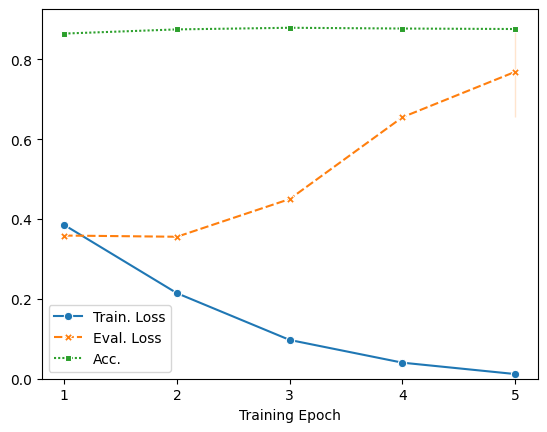

In [95]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_mnli_matched_loss", "epoch", "eval_mnli_matched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training  Epochs (matched {PRE_TRAINED_CHECKPOINT})"))

### Loss and Evaluation Metrics over Training Steps (mismatched answerdotai/ModernBERT-large)

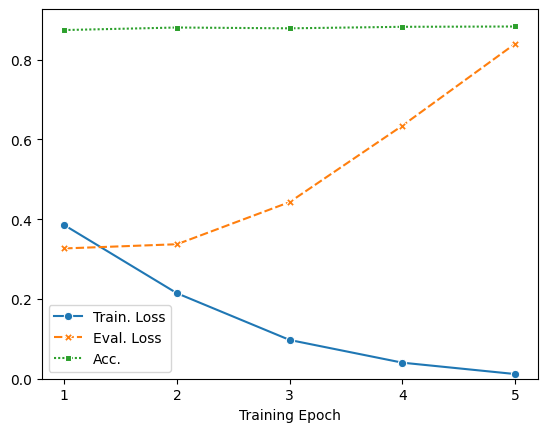

In [96]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_mnli_mismatched_loss", "epoch", "eval_mnli_mismatched_accuracy", ]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Epoch']).dropna()


plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Steps (mismatched {PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [97]:
predictions_matched = trainer.predict(tokenized_dataset["test_matched"])
predictions_mismatched = trainer.predict(tokenized_dataset["test_mismatched"])

### Prediction Confusion Matrix (matchded - answerdotai/ModernBERT-large)

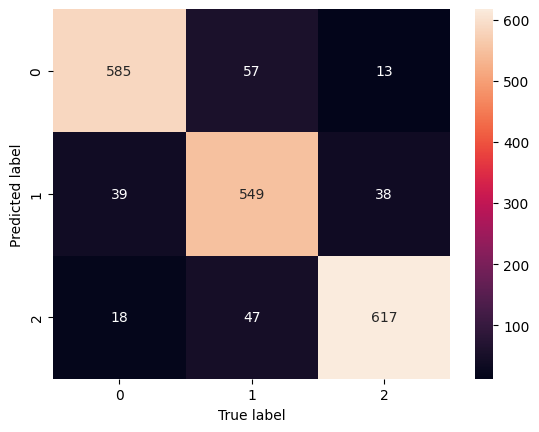

In [98]:
import sklearn.metrics

modernbert_large_matched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_matched"]["label"],
    predictions_matched.predictions.argmax(-1),
)
plot = sns.heatmap(modernbert_large_matched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(f"### Prediction Confusion Matrix (matchded - {PRE_TRAINED_CHECKPOINT})")
)

### Prediction Confusion Matrix (mismatchded - answerdotai/ModernBERT-large)

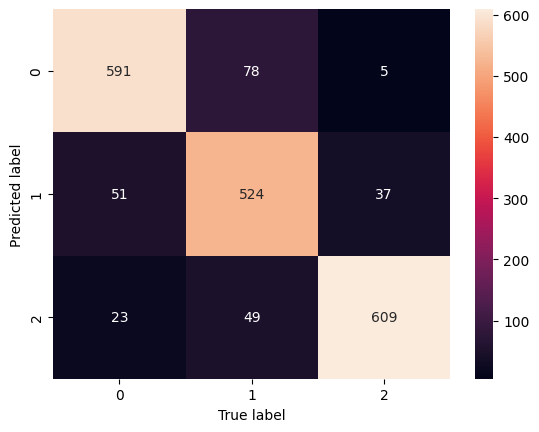

In [99]:
import sklearn.metrics

modernbert_large_mismatched_cm = sklearn.metrics.confusion_matrix(
    tokenized_dataset["test_mismatched"]["label"],
    predictions_mismatched.predictions.argmax(-1),
)
plot = sns.heatmap(modernbert_large_mismatched_cm, annot=True, fmt="d")
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display

display(
    Markdown(
        f"### Prediction Confusion Matrix (mismatchded - {PRE_TRAINED_CHECKPOINT})"
    )
)

In [100]:
predictions_matched.metrics

{'test_loss': 0.5690864324569702,
 'test_accuracy': 0.8920020376974019,
 'test_runtime': 3.2623,
 'test_samples_per_second': 601.714,
 'test_steps_per_second': 19.005}

In [101]:
predictions_mismatched.metrics

{'test_loss': 0.6984425187110901,
 'test_accuracy': 0.8764616166751398,
 'test_runtime': 3.1076,
 'test_samples_per_second': 632.97,
 'test_steps_per_second': 19.951}

In [102]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_mnli_matched_loss"],
    best_model_evaluation["eval_mnli_matched_accuracy"],
    best_model_evaluation["eval_mnli_mismatched_loss"],
    best_model_evaluation["eval_mnli_mismatched_accuracy"],
    best_model_evaluation["eval_accuracy_avg"],
    predictions_matched.metrics["test_accuracy"],
    predictions_mismatched.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,8199.380200,-,5936.776400,25481.052300,-,5936.776400
eval_mnli_matched_loss,0.629729,-,0.654255,0.680571,-,0.655289
eval_mnli_matched_accuracy,0.838512,-,0.869715,0.862837,-,0.877356
eval_mnli_mismatched_loss,0.574196,-,0.636879,0.677831,-,0.634532
eval_mnli_mismatched_accuracy,0.848442,-,0.874889,0.859758,-,0.882263
eval_accuracy_avg,0.843477,-,0.872302,0.861298,-,0.879810
matched_test_accuracy,0.864493,0.846,0.884870,0.882323,0.867,0.892002
mismatched_test_accuracy,0.842908,0.834,0.869344,0.853584,0.859,0.876462


# Summary

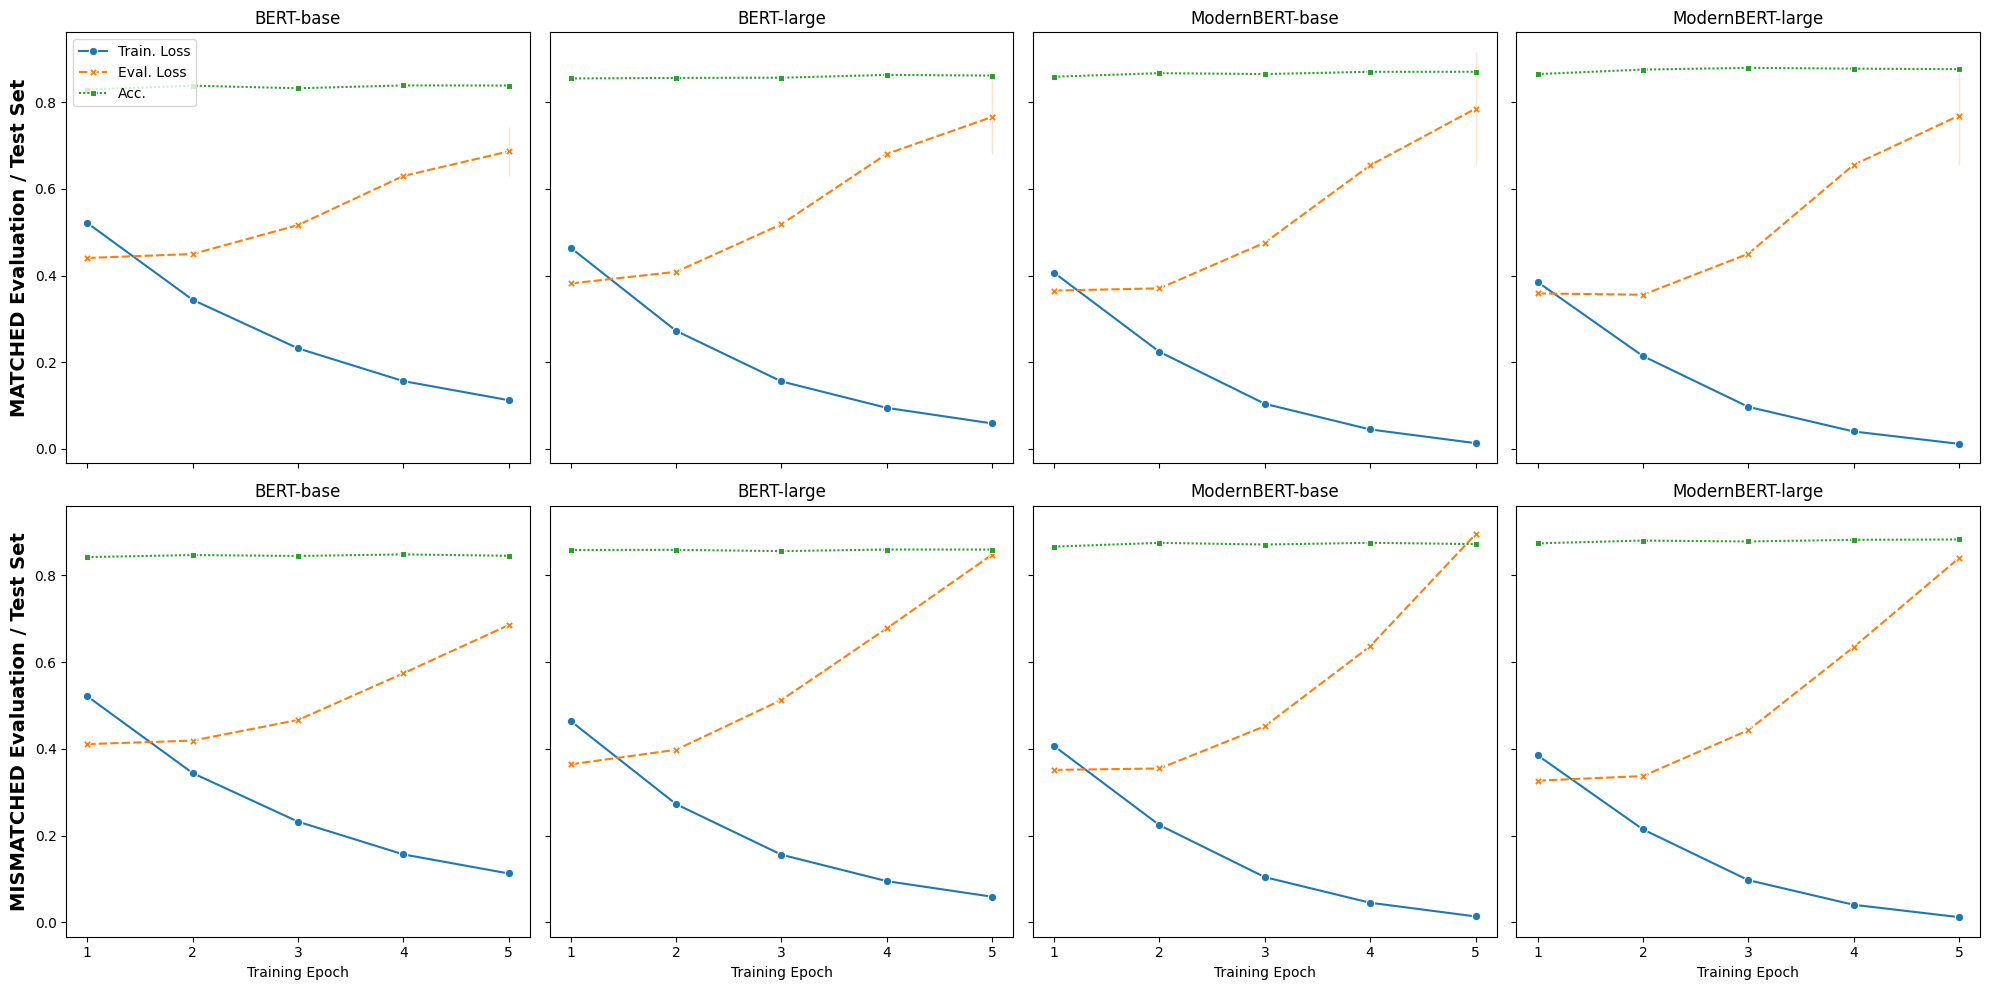

In [103]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(nrows=2,ncols=len(training_histories), sharey=True, sharex=True)

def draw_loss_eval_plot(title, history, ax, mismatched=False):
    eval_loss_key = "eval_mnli_mismatched_loss" if mismatched else "eval_mnli_matched_loss"
    eval_acc_key = "eval_mnli_mismatched_accuracy" if mismatched else "eval_mnli_matched_accuracy"

    data = history[["loss", eval_loss_key, "epoch", eval_acc_key]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes[0]):
    draw_loss_eval_plot(title, history, ax)
for title, history, ax in zip(titles, training_histories, axes[1]):
    draw_loss_eval_plot(title, history, ax, mismatched=True)

for ax in axes[0][1:]:
    ax.get_legend().remove()
for ax in axes[1]:
    ax.get_legend().remove()

axes[0][0].set_ylabel("MATCHED Evaluation / Test Set", weight='bold', fontsize=14)
axes[1][0].set_ylabel("MISMATCHED Evaluation / Test Set", weight='bold', fontsize=14)

fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [104]:
titles

['BERT-base', 'BERT-large', 'ModernBERT-base', 'ModernBERT-large']

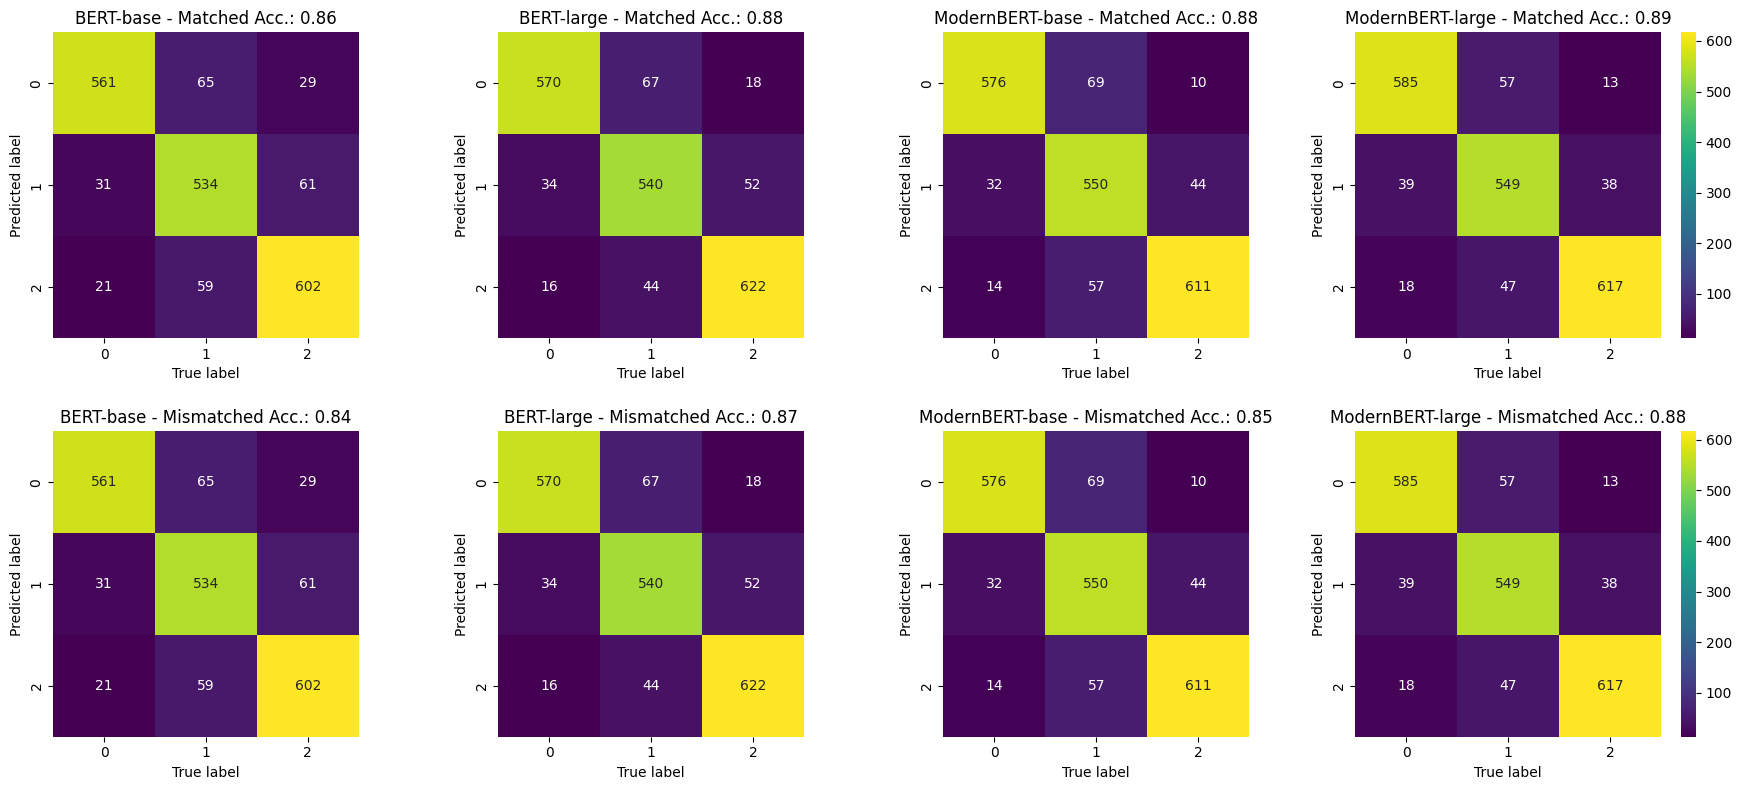

In [105]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
our_results_matched = (
    results.loc["matched_test_accuracy"]
    .drop("original BERT_BASE")
    .drop("original BERT_LARGE")
)
our_results_mismatched = (
    results.loc["mismatched_test_accuracy"]
    .drop("original BERT_BASE")
    .drop("original BERT_LARGE")
)
titles_matched = [
    title + " - " + f"Matched Acc.: {matched_acc:.2f}"
    for title, matched_acc in zip(titles, our_results_matched)
]
titles_mismatched = [
    title + " - " + f"Mismatched Acc.: {mismatched_acc:.2f}"
    for title, mismatched_acc in zip(titles, our_results_mismatched)
]
matched_cms = [
    bert_base_matched_cm,
    bert_large_matched_cm,
    modernbert_base_matched_cm,
    modernbert_large_matched_cm,
]
mismatched_cms = [
    bert_base_mismatched_cm,
    bert_large_mismatched_cm,
    modernbert_base_mismatched_cm,
    modernbert_large_mismatched_cm,
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(4.2, 4.2))


def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title in (titles_matched[-1], titles_mismatched[-1])
    plot = sns.heatmap(
        cm, annot=True, fmt="d", square=True, cmap="viridis", cbar=include_cbar, ax=ax
    )
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)


for title, history, ax in zip(titles_matched, matched_cms, axes[0]):
    draw_confusion_matrix_plot(title, history, ax)
for title, history, ax in zip(titles_mismatched, matched_cms, axes[1]):
    draw_confusion_matrix_plot(title, history, ax)


fig.set_figwidth(18)
fig.set_figheight(8)
fig.tight_layout(h_pad=2)

In [106]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,8199.380200,-,5936.776400,25481.052300,-,5936.776400
eval_mnli_matched_loss,0.629729,-,0.654255,0.680571,-,0.655289
eval_mnli_matched_accuracy,0.838512,-,0.869715,0.862837,-,0.877356
eval_mnli_mismatched_loss,0.574196,-,0.636879,0.677831,-,0.634532
eval_mnli_mismatched_accuracy,0.848442,-,0.874889,0.859758,-,0.882263
eval_accuracy_avg,0.843477,-,0.872302,0.861298,-,0.879810
matched_test_accuracy,0.864493,0.846,0.884870,0.882323,0.867,0.892002
mismatched_test_accuracy,0.842908,0.834,0.869344,0.853584,0.859,0.876462


In [107]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.3811165601588093)